In [1]:
# Import relevant modules and dataset

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score, roc_auc_score
import sklearn.metrics as metrics
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

allrecipes_df = pd.read_csv('allrecipes_data.csv', index_col = [0])

# Data preprocessing

types_of_meat = ['chicken', 'beef', 'turkey', 'poultry', 'lamb', 'pork', 'ham', 'bacon', 'sausage', 'salami', 'meat', 'ribs']

allrecipes_df['has_meat'] = allrecipes_df['ingredients'].apply(lambda x: any(s.lower() in x for s in types_of_meat))
has_meat = allrecipes_df['has_meat']

# Remove columns with object datatype
data = allrecipes_df.drop(columns = ['name', 'yield', 'nutrition', 'ingredients'])

# Check for columns with high number of null values and remove them
data.isnull().sum()
data = data.drop(columns = ['cook', 'additional', 'cholesterol [mg]'])

# Drop all rows with null values in any of the remaining columns
data.dropna(inplace = True)

# Correlation matrix - mask is applied to remove only one of two highly correlated features in the next step

corr_matrix = data.corr().abs()

mask = np.triu(np.ones_like(corr_matrix, dtype = bool))

tri_df = corr_matrix.mask(mask)

# Dropping features with high correlation

to_drop = [c for c in tri_df.columns if any(tri_df[c] >= 0.8)]

data.drop(columns = to_drop, inplace = True)

# Remove dependent feature (considering it's a boolean)

X = data.iloc[:, :-1]
y = data.iloc[:, -1]

# Verify VIF values for remaining features - print 5 highest scored features (not including const).
# All less than 10 means that features are fine.
# If value is over 10 feature is considered to have high multicollinearity and should be removed to avoid overfitting
X = add_constant(X)
pd.Series([variance_inflation_factor(X.values, i) 
               for i in range(X.shape[1])], 
              index=X.columns).sort_values(ascending = False).head(6).tail(5)

1 stars              2.620955
pepper               2.594935
number_of_reviews    2.575376
protein [g]          2.227576
garlic               2.017040
dtype: float64

In [2]:
# Normalize data

from sklearn.preprocessing import MinMaxScaler
columns = X.columns
norm = MinMaxScaler()
X_norm = norm.fit_transform(X)
X_norm = pd.DataFrame(X_norm, columns = columns)

pd.set_option('display.float_format', lambda x: '%.3f' % x)
X_norm.head()

,const,prep,total,servings,1 stars,recipe_score,number_of_reviews,protein [g],carbohydrates [g],fat [g],...,oregano,thyme,cayenne pepper,sesame,clove,cumin,ginger,basil,paprika,mustard
0,0.000,0.019,0.009,0.042,0.148,0.856,0.235,0.336,0.006,0.200,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1,0.000,0.008,0.002,0.017,0.102,0.781,0.116,0.115,0.183,0.040,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2,0.000,0.050,0.002,0.160,0.053,0.860,0.060,0.046,0.310,0.060,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
3,0.000,0.019,0.003,0.025,0.110,0.707,0.050,0.288,0.300,0.209,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
4,0.000,0.019,0.023,0.025,0.000,0.750,0.001,0.359,0.047,0.229,...,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000


In [3]:
# Train data

X = X_norm.values
y = y.values.astype(int)

X_train, X_test, y_train, y_test = train_test_split (X, y, test_size=0.2, random_state=0)

print('X_train:', np.shape(X_train))
print('y_train:', np.shape(y_train))
print('X_test:', np.shape(X_test))
print('y_test:', np.shape(y_test))

classifier = LogisticRegression()
classifier.fit(X_train,y_train)

X_train: (729, 32)
y_train: (729,)
X_test: (183, 32)
y_test: (183,)


LogisticRegression()

In [4]:
# Predict the results
y_pred = classifier.predict(X_test)

# Print 5 first comparisons between y_pred and y_test
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1)[:5])

[[1 1]
 [0 1]
 [0 1]
 [0 0]
 [0 1]]


[[91 24]
 [25 43]]


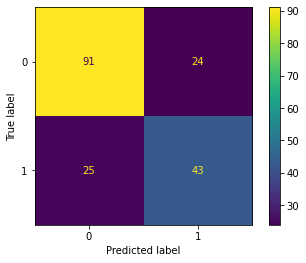

In [5]:
# Confusion matrix

cm = confusion_matrix(y_test, y_pred)
print(cm)

plot_confusion_matrix(classifier, X_test, y_test)  
plt.show()

In [6]:
logreg=accuracy_score(y_test,y_pred)
print(f'Model accuracy: {logreg * 100:.2f}%')

roc_auc = roc_auc_score(y_test, y_pred)
print(f'AUC-ROC score value: {roc_auc:.3f}')

Model accuracy: 73.22%
AUC-ROC score value: 0.712


In [7]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.79      0.79       115
           1       0.64      0.63      0.64        68

    accuracy                           0.73       183
   macro avg       0.71      0.71      0.71       183
weighted avg       0.73      0.73      0.73       183



In [8]:
parameters_lr = [{'penalty':['l1','l2'],'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}]
grid_search_lr = GridSearchCV(estimator = classifier,
                           param_grid = parameters_lr,
                           scoring = 'accuracy',
                           cv = 10,
                           n_jobs = -1)
grid_search_lr.fit(X_train, y_train)
best_accuracy_lr = grid_search_lr.best_score_
best_paramaeter_lr = grid_search_lr.best_params_  
print("Best Accuracy of LR: {:.2f} %".format(best_accuracy_lr.mean()*100))
print("Best Parameter of LR:", best_paramaeter_lr)

Best Accuracy of LR: 80.52 %
Best Parameter of LR: {'C': 100, 'penalty': 'l2'}
